# Projection On Capped Simplex

In [34]:
import numpy as np
from tqdm import tqdm

N = 10000
C = 1000
w_n = 1
eps = 1e-32
T = 2 * 10 ** 5

def custom_zipf(N: int, a: float, T: int):
    """Generate a custom zipf"""
    ns = np.arange(N)
    ps = (1 / (ns+1) ** a) 
    ps = ps / sum(ps)
    return np.random.choice(ns, size=T, p=ps)
#REQUESTS = np.random.random_integers(0,N, T)
#REQUESTS = np.concatenate(
#        [custom_zipf(N, 0.64, T // 2),
#         custom_zipf(N, 0.82, T//2)
#        #np.random.random_integers(0,N, T//2)
#         ]) #np.random.zipf(1.2, T)
REQUESTS = custom_zipf(N, 0.64, T)
#N = max(REQUESTS)

print("MAX:", max(REQUESTS)) #np.array([1.2,0.0,0.0,0.0,0.0,.0,.0,.0,.0,.0])
#REQUESTS = REQUESTS[REQUESTS < N] 

MAX: 9999


In [35]:
import time
loop1, loop2 = 0,0

def oga_epoch(Z: np.ndarray):
    """
    """

    zdx = np.argsort(Z, kind="heapsort")[::-1]
    sorted_z = Z[zdx]
    y = np.zeros(N)
    M1 = set()
    M2 = set(range(N))
    M3 = set()
    
    while True:

        if not M2:
            break

        rho = 2 * (len(M1) - C + sorted_z[list(M2)].sum()) / len(M2)

        #for n in range(N):
        #    if n in M1:
        #        y[n] = 1
        #    elif n in M2:
        #        y[n] = sorted_z[n] - rho / 2
        #    elif n in M3:
        #        y[n] = 0

        y[list(M1)] = 1
        y[list(M2)] = sorted_z[list(M2)] - rho / 2
        y[list(M3)] = 0

        S = {n for n in M2 if y[n] < 0}
        M2.difference_update(S)
        M3.update(S)

        if not S:
            break
        
        
    if y[0] > 1:
        M1 = {0}
        M2 = set(range(1,N))
        M3 = set()
        while True:

            if not M2:
                break

            rho = 2 * (len(M1) - C + sorted_z[list(M2)].sum()) / len(M2)

            y[list(M1)] = 1
            y[list(M2)] = sorted_z[list(M2)] - rho / 2
            y[list(M3)] = 0

            S = {n for n in M2 if y[n] < 0}
            M2.difference_update(S)
            M3.update(S)

            if not S:
                break
    og_order = np.zeros(N)
    for i, val in zip(zdx, y):
        og_order[i] = val

    return og_order


In [37]:
REQUESTS = np.array([0,1,0])
y = np.array([0.5,0.5])
N = 2
T = REQUESTS.shape[0]
C = 1.5
for req in REQUESTS:
    y[req] += 1
    print(f"Z= {y}")
    y = oga_epoch(y)
    print(f"Y={y}")
    print("-"*10)



Z= [1.5 0.5]
Y=[1.  0.5]
----------
Z= [2.  0.5]
Y=[1.  0.5]
----------
Z= [1.  1.5]
Y=[0.5 1. ]
----------
Z= [1.5 1. ]
Y=[1.  0.5]
----------


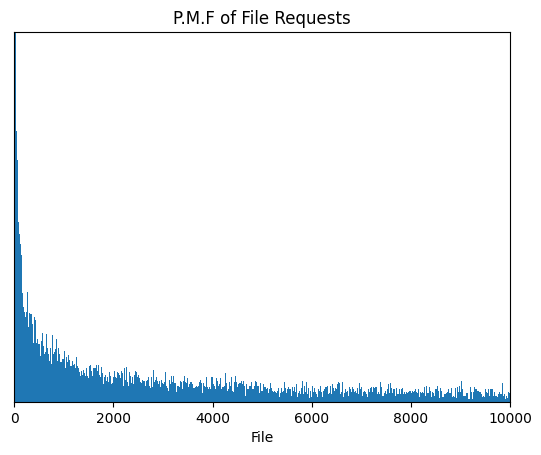

In [29]:
import matplotlib.pyplot as plt
ax = plt.subplot()

plt.hist(REQUESTS, bins=N)
plt.xlim([-10, 10000])
plt.ylim([0, 300])
plt.xlabel("File")
plt.ylabel("Request Probability")
plt.title("P.M.F of File Requests")
ax.yaxis.set_visible(False)

In [6]:
conv_rates = {}

OGA Implementation


Loop1: 0 | Loop2: 0 | Avg Hits: 0.39195065028928827 | sigma y: 1000.0000000000015: 100%|██████████| 200000/200000 [16:31<00:00, 201.69it/s]


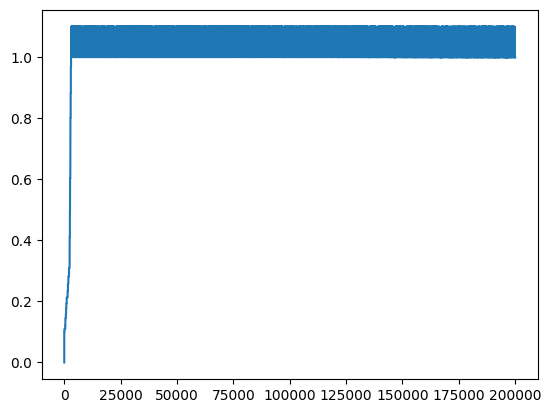

In [7]:


Z = np.zeros(N)
y = np.zeros(N)
M1, M2, M3 = set(), set(), set()

print("OGA Implementation")
hits = [] 
rolling_avg = {"oga":[], "lru":[], "lfu":[], "static":[]}
eta = 0.1
first_y = []
pbar = tqdm(enumerate(REQUESTS), total=len(REQUESTS))
for idx, req in pbar:

    hits.append(y[req - 1])
    y[req - 1] += eta * w_n * y[req - 1]
    first_y.append(y[0])
    #hits.append(1 if (req - 1) in M2 else 0)
    hits = hits[-1000:]
    rolling_avg["oga"].append(sum(hits) / (len(hits) + 1))
    y = oga_epoch(y)
    pbar.set_description(f"Loop1: {loop1} | Loop2: {loop2} | Avg Hits: {sum(hits) / (len(hits) + 1)} | sigma y: {sum(y)}")

conv_rates[eta] = rolling_avg["oga"][:]
plt.plot(first_y)


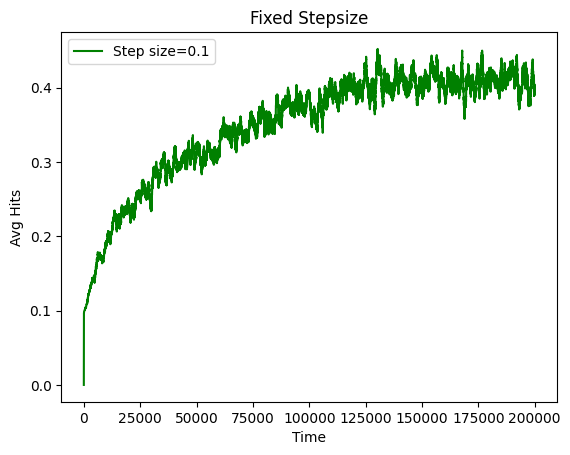

In [8]:
#plt.plot(y)
highlights = {
    0.1:"green",
}
for name, data in conv_rates.items():
    if name not in highlights:
        plt.plot(data, label=f"Step size={name}", color=highlights.get(name,"grey"))

for name, data in conv_rates.items():
    if name in highlights:
        plt.plot(data, label=f"Step size={name}", color=highlights.get(name,"grey"))

plt.title("Fixed Stepsize")
plt.xlabel("Time")
plt.ylabel("Avg Hits")
plt.legend()

In [9]:
lru_cache = []
pbar = tqdm(enumerate(REQUESTS), total=len(REQUESTS))
hits = []

for idx, req in pbar:
    if (req - 1) in lru_cache:
        hits.append(1)
        lru_cache = list(filter(lambda item: item != req - 1, lru_cache))
        lru_cache.append(req - 1)
    else:
        hits.append(0)
        lru_cache.append(req - 1)

    hits = hits[-1000:]
    rolling_avg["lru"].append(sum(hits) / (len(hits)+1))
    lru_cache = lru_cache[-C:]

    pbar.set_description(f"Avg Hits: {sum(hits) / (len(hits) + 1)} | {len(lru_cache)}")



Avg Hits: 0.2677322677322677 | 1000: 100%|██████████| 200000/200000 [01:11<00:00, 2804.16it/s] 


In [10]:
#LFU
freqs = np.zeros(N)
pbar = tqdm(enumerate(REQUESTS), total=len(REQUESTS))
hits = []

for idx, req in pbar:

    if req-1 in np.argsort(freqs)[-C:]:
        hits.append(1)
    else:
        hits.append(0)

    hits = hits[-1000:]
    rolling_avg["lfu"].append(sum(hits) / (len(hits)+1))
    pbar.set_description(f"Avg Hits: {sum(hits) / (len(hits) + 1)}")
    freqs[req - 1] += 1




Avg Hits: 0.3806193806193806: 100%|██████████| 200000/200000 [01:54<00:00, 1745.44it/s] 


In [11]:
#static policy
_ , counts = np.unique(REQUESTS, return_counts=True)
static_cache = np.argsort(counts)[-C:]

pbar = tqdm(enumerate(REQUESTS), total=len(REQUESTS))
hits = []

for idx, req in pbar:

    if req-1 in static_cache:
        hits.append(1)
    else:
        hits.append(0)

    hits = hits[-1000:]
    rolling_avg["static"].append(sum(hits) / (len(hits)+1))
    pbar.set_description(f"Avg Hits: {sum(hits) / (len(hits) + 1)}")



Avg Hits: 0.42857142857142855:   0%|          | 0/200000 [00:00<?, ?it/s]

Avg Hits: 0.3826173826173826: 100%|██████████| 200000/200000 [01:05<00:00, 3038.06it/s] 


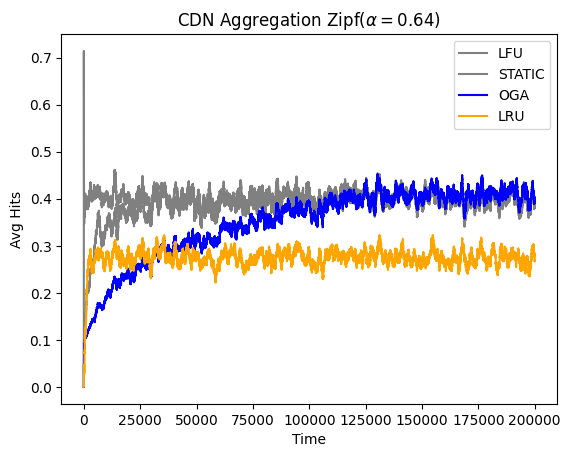

In [33]:
highlight = {
    "lru":"orange",
    "oga":"blue"
}
for name, data in rolling_avg.items():
    if name not in highlight:
        plt.plot(data, label=name.upper(), color="grey")

for name, data in rolling_avg.items():
    if name in highlight:
        plt.plot(data, label=name.upper(),color=highlight[name])

plt.title("CDN Aggregation Zipf($\\alpha = 0.64$)")
plt.ylabel("Avg Hits")
plt.xlabel("Time")
plt.legend()